# 1. 가설
- 비슷한 품목끼리 비슷하게 무역하지 않을까 하는 가설
- 가장 유의미한 그룹을 찾아보자

# 2. 시각화

In [2]:
%pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('C:\\Project\\data-contest-lab\\competitions\\2025-kookmin-aibd\\01_data\\raw\\data\\train.csv')
df_hs4 = pd.read_csv("C:\\Project\\data-contest-lab\\competitions\\2025-kookmin-aibd\\01_data\\raw\\data\\hs4_c.csv")

In [8]:
# 한글 폰트 설정 (필요하면)
plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우
plt.rcParams['axes.unicode_minus'] = False

In [9]:
# 2. ym 컬럼 만들기
df["ym"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-01")

# 3. hs4 → hs2 매핑
df_hs4["hs2"] = df_hs4["hs4"].astype(str).str[:2]

df_item = df[["item_id", "hs4"]].drop_duplicates()
df_item = df_item.merge(df_hs4[["hs4", "hs2"]], on="hs4", how="left")

# item_id 기준 hs2 매핑 딕셔너리
item2hs2 = df_item.set_index("item_id")["hs2"].to_dict()

# 4. 원본 df에 hs2 붙이기
df["hs2"] = df["item_id"].map(item2hs2)

# 5. 월별 집계 (item_id, hs2, ym)
monthly = (
    df.groupby(["hs2", "item_id", "ym"], as_index=False)["value"]
      .sum()
)

hs2
28    21
38    10
85     9
30     4
81     4
25     3
87     3
32     3
84     3
72     3
51     2
27     2
44     2
56     2
55     2
48     2
31     2
39     2
43     1
26     1
90     1
60     1
79     1
21     1
29     1
12     1
94     1
33     1
52     1
34     1
42     1
62     1
61     1
57     1
46     1
20     1
54     1
53     1
71     1
Name: count, dtype: int64


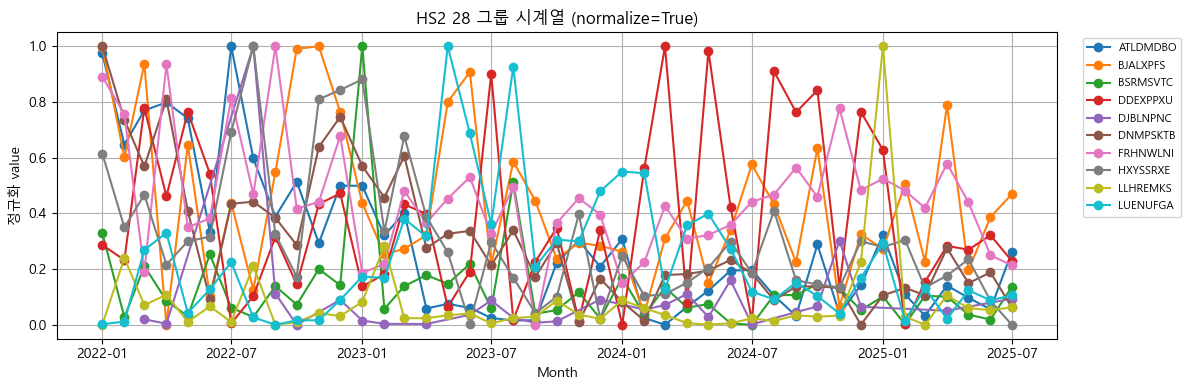

In [10]:
def plot_hs2_timeseries(hs2_code, normalize=True, max_items=10):
    """
    hs2_code: 문자열 또는 정수 (예: "28", 28)
    normalize: 아이템별로 min-max 정규화해서 모양만 비교할지 여부
    max_items: 너무 많으면 복잡하니 최대 몇 개까지만 그릴지
    """
    hs2_str = str(hs2_code).zfill(2)

    g = monthly[monthly["hs2"] == hs2_str]
    if g.empty:
        print(f"HS2 {hs2_str} 그룹 데이터가 없습니다.")
        return

    items = g["item_id"].unique()[:max_items]  # 상위 max_items개만
    plt.figure(figsize=(12, 4))
    ax = plt.gca()

    for item in items:
        ts = g[g["item_id"] == item].sort_values("ym")

        y = ts["value"].values.astype(float)
        if normalize:
            if y.max() > y.min():
                y_plot = (y - y.min()) / (y.max() - y.min())
            else:
                y_plot = y  # 전 구간 동일하면 그대로
        else:
            y_plot = y

        ax.plot(ts["ym"], y_plot, marker="o", label=item)

    ax.set_title(f"HS2 {hs2_str} 그룹 시계열 (normalize={normalize})")
    ax.set_xlabel("Month")
    ax.set_ylabel("정규화 value" if normalize else "value")
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()

# 예시: 아이템 많은 hs2 하나 골라서 그리기
hs2_counts = df_item["hs2"].value_counts()
print(hs2_counts)          # 어떤 hs2가 많은지 확인
plot_hs2_timeseries("28")  # 예시로 28번 그룹


=== HS2 28 시계열 ===


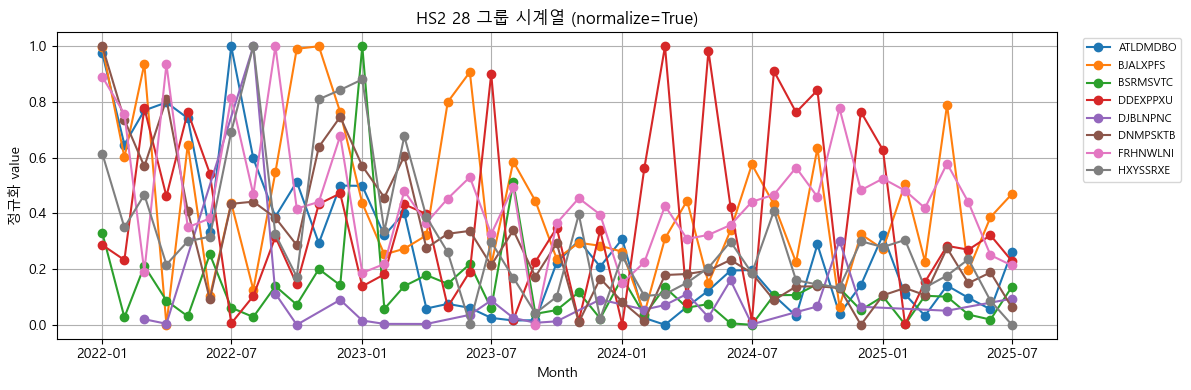

=== HS2 38 시계열 ===


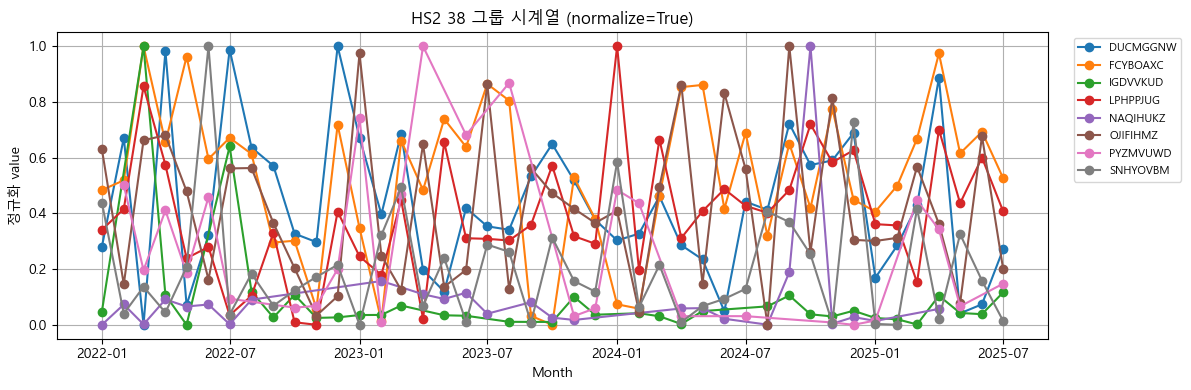

=== HS2 85 시계열 ===


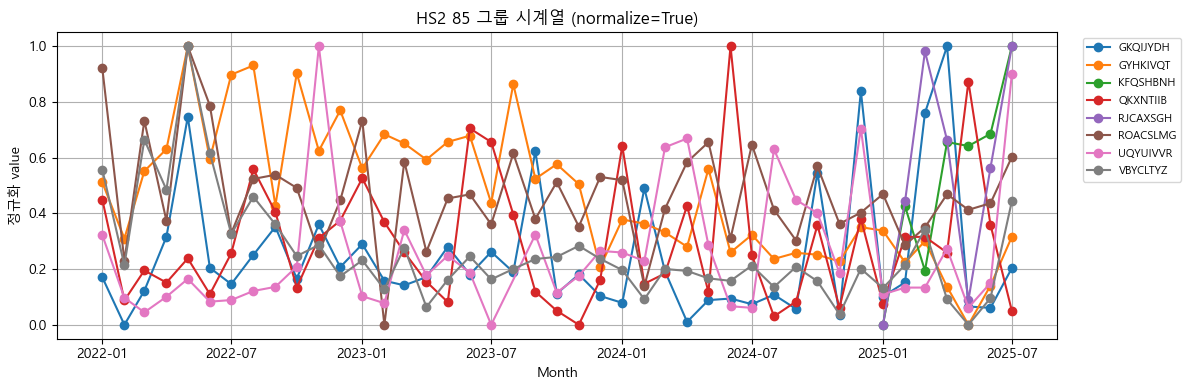

=== HS2 30 시계열 ===


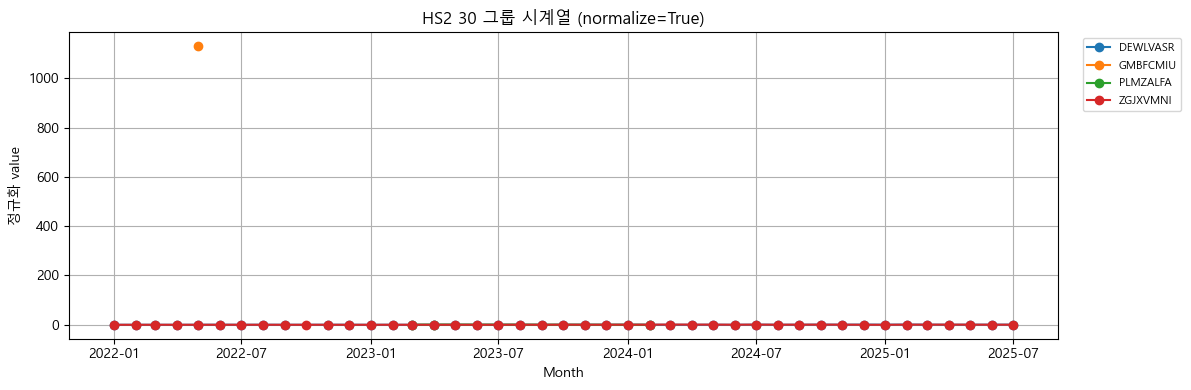

=== HS2 81 시계열 ===


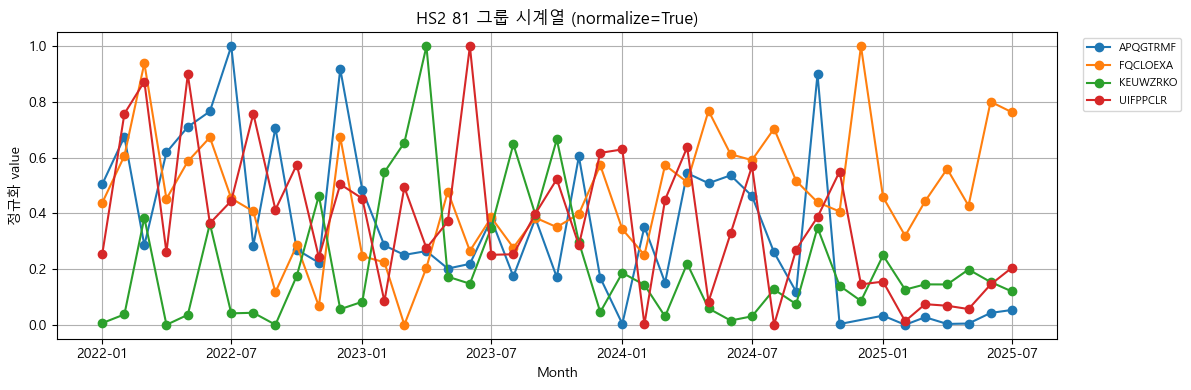

In [11]:
# 아이템 수 기준 상위 N개 hs2만 시각화
topN = 5
top_hs2 = df_item["hs2"].value_counts().head(topN).index.tolist()

for hs2_code in top_hs2:
    print(f"=== HS2 {hs2_code} 시계열 ===")
    plot_hs2_timeseries(hs2_code, normalize=True, max_items=8)


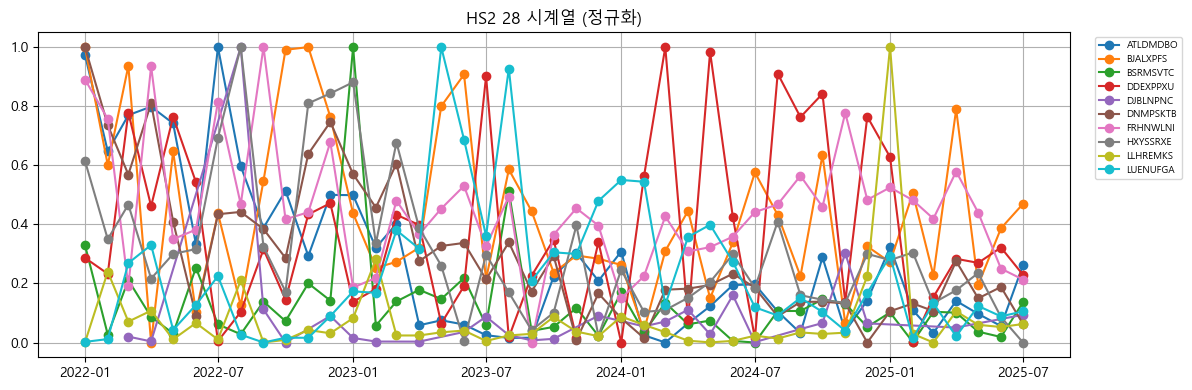

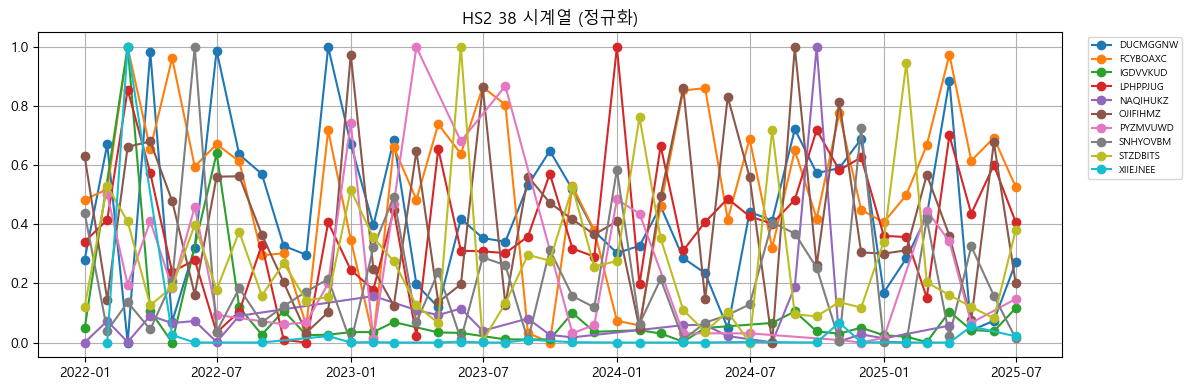

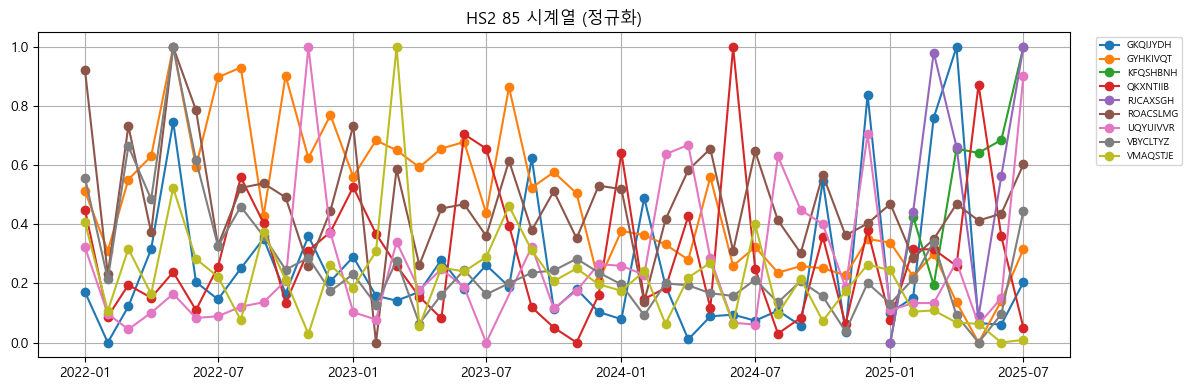

In [13]:
plt.rcParams['axes.unicode_minus'] = False

monthly = df.groupby(["hs2","item_id","ym"], as_index=False)["value"].sum()

# Top3 HS2
top3 = df_item["hs2"].value_counts().head(3).index.tolist()


def plot_hs2(hs2_code, max_items=10):
    g = monthly[monthly["hs2"] == hs2_code]
    items = g["item_id"].unique()[:max_items]

    plt.figure(figsize=(12,4))
    ax = plt.gca()

    for item in items:
        ts = g[g["item_id"] == item].sort_values("ym")
        y = ts["value"].values.astype(float)

        if y.max() > y.min():
            y_plot = (y - y.min()) / (y.max() - y.min())
        else:
            y_plot = y

        ax.plot(ts["ym"], y_plot, marker="o", label=item)

    ax.set_title(f"HS2 {hs2_code} 시계열 (정규화)")
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=7)
    plt.tight_layout()
    plt.show()


# 하나씩 호출
plot_hs2(top3[0])
plot_hs2(top3[1])
plot_hs2(top3[2])


In [14]:
pivot_value = df.pivot_table(
    index="item_id",
    columns="ym",
    values="value",
    aggfunc="sum",
    fill_value=0
).sort_index()

months = pivot_value.columns.sort_values()

# =========================
# 3. hs2 기반 corr 쌍 만들기
# =========================

def build_corr_pairs_hs2(pivot_value, df_item, corr_threshold=0.3, top_k=3):
    """
    hs2 상위 top_k 그룹은 그룹 내부에서만 corr 쌍을 찾고,
    나머지 hs2 그룹은 전체를 하나로 묶어서 corr 쌍을 찾는다.
    반환: DataFrame(leading_item_id, following_item_id, corr, hs2_group_flag)
    """
    # hs2 개수 카운트
    hs2_counts = df_item["hs2"].value_counts()
    top_hs2 = hs2_counts.head(top_k).index.tolist()
    other_hs2 = hs2_counts.index.difference(top_hs2)

    pairs_top = []
    pairs_other = []

    # 3-1. top_hs2 그룹 내부에서 corr
    for hs2_code in top_hs2:
        items = df_item[df_item["hs2"] == hs2_code]["item_id"].tolist()
        sub = pivot_value.loc[pivot_value.index.isin(items)]
        corr_mat = sub.T.corr()

        for a in items:
            for b in items:
                if a == b:
                    continue
                c = corr_mat.loc[a, b]
                if abs(c) >= corr_threshold:
                    pairs_top.append({
                        "leading_item_id": a,
                        "following_item_id": b,
                        "corr": c,
                        "hs2_group": hs2_code,
                        "group_type": "top"
                    })

    # 3-2. 나머지 hs2 전체 묶어서 corr
    items_other = df_item[df_item["hs2"].isin(other_hs2)]["item_id"].tolist()
    sub_other = pivot_value.loc[pivot_value.index.isin(items_other)]
    corr_other = sub_other.T.corr()

    for a in items_other:
        for b in items_other:
            if a == b:
                continue
            c = corr_other.loc[a, b]
            if abs(c) >= corr_threshold:
                pairs_other.append({
                    "leading_item_id": a,
                    "following_item_id": b,
                    "corr": c,
                    "hs2_group": "other",
                    "group_type": "other"
                })

    df_top = pd.DataFrame(pairs_top)
    df_other = pd.DataFrame(pairs_other)
    pairs_final = pd.concat([df_top, df_other], axis=0).reset_index(drop=True)

    return pairs_final, top_hs2, other_hs2

pairs_final, top_hs2, other_hs2 = build_corr_pairs_hs2(
    pivot_value, df_item, corr_threshold=0.3, top_k=3
)

print("TOP3 hs2:", top_hs2)
print("pairs_final shape:", pairs_final.shape)
print(pairs_final.head())

# =========================
# 4. 시간 feature 함수
# =========================

def add_time_features(feat: dict, target_ym: pd.Timestamp) -> dict:
    year = target_ym.year
    month = target_ym.month

    feat["year"] = year
    feat["month"] = month

    # 2022~2025 기준 정규화
    feat["year_norm"] = (year - 2022) / 3.0

    # 2025년 전체 감소 효과
    feat["is_2025"] = 1 if year == 2025 else 0

    # month cyclic
    feat["month_sin"] = np.sin(2 * np.pi * month / 12)
    feat["month_cos"] = np.cos(2 * np.pi * month / 12)

    # 8월 급락 효과
    feat["is_august"] = 1 if month == 8 else 0

    # 7→8 전환 플래그 (target이 8월인 경우만 1)
    feat["is_july_to_august_transition"] = 1 if month == 8 else 0

    return feat

# =========================
# 5. pairs_final 기반 학습 데이터 만들기
#    (lag=0 가정: 같은 달의 leader/follower를 보고,
#     follower의 다음달 value를 예측)
# =========================

def build_training_data_from_pairs(pivot_value, pairs, min_hist=3):
    """
    pivot_value: item_id × ym (value)
    pairs: pairs_final (leading_item_id, following_item_id, corr, ...)
    min_hist: follower의 과거 최소 개월 수 (예: 3개월 이상 있어야 학습에 사용)
    
    반환: df_train (feature + target)
    """
    months = pivot_value.columns.sort_values()
    n_months = len(months)

    rows = []

    for _, row in pairs.iterrows():
        leader = row["leading_item_id"]
        follower = row["following_item_id"]
        corr = row["corr"]
        hs2_group = row["hs2_group"]
        group_type = row["group_type"]

        # 시리즈 가져오기
        if leader not in pivot_value.index or follower not in pivot_value.index:
            continue

        s_leader = pivot_value.loc[leader]
        s_follower = pivot_value.loc[follower]

        # t: 피처를 만드는 기준 시점 index
        # target은 t+1 달의 follower value
        # 과거 min_hist 개월 + 다음 달 target 필요 → t 범위 제한
        for t in range(min_hist, n_months - 1):
            target_idx = t + 1
            target_ym = months[target_idx]

            # follower 과거 값
            f_t   = s_follower.iloc[t]
            f_t_1 = s_follower.iloc[t-1]
            f_t_2 = s_follower.iloc[t-2]
            # 필요하면 더 과거도 추가 가능

            # leader 같은 시점 값 (lag=0 가정)
            l_t   = s_leader.iloc[t]
            l_t_1 = s_leader.iloc[t-1]
            l_t_2 = s_leader.iloc[t-2]

            target = s_follower.iloc[target_idx]

            feat = {
                "leading_item_id": leader,
                "following_item_id": follower,
                "target_ym": target_ym,
                "corr_pair": corr,
                "hs2_group": hs2_group,
                "group_type": group_type,
                # follower value history
                "f_value_t": f_t,
                "f_value_t_1": f_t_1,
                "f_value_t_2": f_t_2,
                # leader value history
                "l_value_t": l_t,
                "l_value_t_1": l_t_1,
                "l_value_t_2": l_t_2,
            }

            # 시간 feature 붙이기
            feat = add_time_features(feat, target_ym)

            feat["target"] = target
            rows.append(feat)

    df_train = pd.DataFrame(rows)
    return df_train

df_train = build_training_data_from_pairs(pivot_value, pairs_final, min_hist=3)
print(df_train.shape)
print(df_train.head())

TOP3 hs2: ['28', '38', '85']
pairs_final shape: (582, 5)
  leading_item_id following_item_id      corr hs2_group group_type
0        RCBZUSIM          WQMVCOEM  0.334255        28        top
1        RCBZUSIM          DNMPSKTB  0.309068        28        top
2        RCBZUSIM          ATLDMDBO  0.431270        28        top
3        RCBZUSIM          HXYSSRXE  0.478416        28        top
4        RCBZUSIM          QRKRBYJL  0.576177        28        top
(22698, 21)
  leading_item_id following_item_id  target_ym  corr_pair hs2_group  \
0        RCBZUSIM          WQMVCOEM 2022-05-01   0.334255        28   
1        RCBZUSIM          WQMVCOEM 2022-06-01   0.334255        28   
2        RCBZUSIM          WQMVCOEM 2022-07-01   0.334255        28   
3        RCBZUSIM          WQMVCOEM 2022-08-01   0.334255        28   
4        RCBZUSIM          WQMVCOEM 2022-09-01   0.334255        28   

  group_type  f_value_t  f_value_t_1  f_value_t_2  l_value_t  ...  \
0        top   171387.0       732

In [15]:
# =========================
# 2. Identify hs2 Top 3 groups
# =========================
hs2_counts = df_item["hs2"].value_counts()
top3_hs2 = hs2_counts.head(3).index.tolist()
others_hs2 = hs2_counts.index.difference(top3_hs2)

print("Top3 HS2:", top3_hs2)
print("Others:", list(others_hs2))


# =========================
# 3. 연도별 감소율 계산
# =========================
def calc_reduction(series):
    """2025 vs 과거 평균 대비 감소율 계산"""
    base = series.loc[2022:2024].mean()
    val_2025 = series.loc[2025]
    return (val_2025 - base) / base   # 음수가 감소율

# 전체 감소율
yearly_total = df.groupby("year")["value"].sum()
total_reduction = calc_reduction(yearly_total)

print("\n[전체 감소율]")
print(total_reduction)


# =========================
# 4. HS2 그룹별 연 감소율 계산
# =========================
hs2_year_reduction = {}

for hs2_code in top3_hs2:
    sub = df[df["hs2"] == hs2_code]
    yearly = sub.groupby("year")["value"].sum()

    # 2025에 데이터 없는 hs2일 경우 대비
    if 2025 not in yearly.index:
        continue

    hs2_year_reduction[hs2_code] = calc_reduction(yearly)

print("\n[HS2 Top3 연도 감소율]")
print(hs2_year_reduction)


# =========================
# 5. 월별 감소율 계산 (전체)
# =========================
monthly_total = df.groupby("month")["value"].sum()

# 7→8월 감소율
drop_7_to_8 = (monthly_total.loc[8] - monthly_total.loc[7]) / monthly_total.loc[7]

print("\n전체 월별 7→8 감소율:", drop_7_to_8)


# =========================
# 6. HS2 Top3 월별 감소율
# =========================
hs2_month_reduction = {}

for hs2_code in top3_hs2:
    sub = df[df["hs2"] == hs2_code]
    monthly = sub.groupby("month")["value"].sum()
    
    if 7 not in monthly.index or 8 not in monthly.index:
        continue
    
    hs2_month_reduction[hs2_code] = (monthly.loc[8] - monthly.loc[7]) / monthly.loc[7]

print("\n[HS2 Top3 7→8 감소율]")
print(hs2_month_reduction)


# =========================
# 7. 최종 보정 계수 테이블 만들기
# =========================
correction_table = []

for hs2_code in top3_hs2:
    correction_table.append({
        "hs2": hs2_code,
        "type": "top3",
        "year_reduction": hs2_year_reduction.get(hs2_code, total_reduction),
        "month_drop_7to8": hs2_month_reduction.get(hs2_code, drop_7_to_8),
        "final_factor": 1 + hs2_year_reduction.get(hs2_code, total_reduction)
    })

# 나머지 hs2는 전체 감소율을 그대로 따른다
for hs2_code in others_hs2:
    correction_table.append({
        "hs2": hs2_code,
        "type": "others",
        "year_reduction": total_reduction,
        "month_drop_7to8": drop_7_to_8,
        "final_factor": 1 + total_reduction
    })

correction_df = pd.DataFrame(correction_table)

print("\n===== 최종 보정 계수 테이블 =====")
print(correction_df)

Top3 HS2: ['28', '38', '85']
Others: ['12', '20', '21', '25', '26', '27', '29', '30', '31', '32', '33', '34', '39', '42', '43', '44', '46', '48', '51', '52', '53', '54', '55', '56', '57', '60', '61', '62', '71', '72', '79', '81', '84', '87', '90', '94']

[전체 감소율]
-0.4697978876120424

[HS2 Top3 연도 감소율]
{'28': -0.5586685739603997, '38': -0.397145429821262, '85': -0.4273196660475062}

전체 월별 7→8 감소율: -0.2092541135378244

[HS2 Top3 7→8 감소율]
{'28': -0.28595018316219206, '38': -0.21261326126160016, '85': -0.16321646558852645}

===== 최종 보정 계수 테이블 =====
   hs2    type  year_reduction  month_drop_7to8  final_factor
0   28    top3       -0.558669        -0.285950      0.441331
1   38    top3       -0.397145        -0.212613      0.602855
2   85    top3       -0.427320        -0.163216      0.572680
3   12  others       -0.469798        -0.209254      0.530202
4   20  others       -0.469798        -0.209254      0.530202
5   21  others       -0.469798        -0.209254      0.530202
6   25  others 

In [19]:
# =========================
# 0. 설정값 (원하면 숫자만 바꿔서 튜닝)
# =========================
CORR_BUILD_TH = 0.3   # 공행성 후보쌍 만들 때 기준
CORR_PRED_TH  = 0.4   # 실제 예측(P)에 쓸 강한 쌍 기준
TARGET_YM_STR = "2025-08-01"
OUTPUT_PATH   = "submission_filtered.csv"

In [29]:
# =========================
# 1. 데이터 로드
# =========================
train = pd.read_csv('C:\\Project\\data-contest-lab\\competitions\\2025-kookmin-aibd\\01_data\\raw\\data\\train.csv')
df_hs4 = pd.read_csv("C:\\Project\\data-contest-lab\\competitions\\2025-kookmin-aibd\\01_data\\raw\\data\\hs4_c.csv")
sub_base = pd.read_csv("C:\\Project\\data-contest-lab\\competitions\\2025-kookmin-aibd\\01_data\\raw\\data\\sample_submission.csv")  # pair 목록 참고용

train["ym"] = pd.to_datetime(
    train["year"].astype(str) + "-" + train["month"].astype(str) + "-01"
)

# =========================
# 2. hs2 매핑 (hs4 앞 두 자리)
# =========================
df_hs4["hs2"] = df_hs4["hs4"].astype(str).str[:2]

df_item = train[["item_id", "hs4"]].drop_duplicates()
df_item = df_item.merge(df_hs4[["hs4", "hs2"]], on="hs4", how="left")

item2hs2 = df_item.set_index("item_id")["hs2"].to_dict()
train["hs2"] = train["item_id"].map(item2hs2)

# =========================
# 3. pivot_value (item × 월 value)
# =========================
pivot_value = train.pivot_table(
    index="item_id",
    columns="ym",
    values="value",
    aggfunc="sum",
    fill_value=0
).sort_index()

months = pivot_value.columns.sort_values()
n_months = len(months)

# =========================
# 4. hs2 기반 공행성 후보쌍 만들기
# =========================
def build_corr_pairs_hs2(pivot_value, df_item, corr_threshold=0.3, top_k=3):
    hs2_counts = df_item["hs2"].value_counts()
    top_hs2 = hs2_counts.head(top_k).index.tolist()
    other_hs2 = hs2_counts.index.difference(top_hs2)

    pairs_top = []
    pairs_other = []

    # Top hs2 그룹 내부 corr
    for hs2_code in top_hs2:
        items = df_item[df_item["hs2"] == hs2_code]["item_id"].tolist()
        sub = pivot_value.loc[pivot_value.index.isin(items)]
        if sub.shape[0] < 2:
            continue
        corr_mat = sub.T.corr()

        for a in items:
            for b in items:
                if a == b:
                    continue
                c = corr_mat.loc[a, b]
                if abs(c) >= corr_threshold:
                    pairs_top.append({
                        "leading_item_id": a,
                        "following_item_id": b,
                        "corr": c,
                        "hs2_group": hs2_code,
                        "group_type": "top"
                    })

    # 나머지 hs2 전체 corr
    items_other = df_item[df_item["hs2"].isin(other_hs2)]["item_id"].tolist()
    sub_other = pivot_value.loc[pivot_value.index.isin(items_other)]
    if sub_other.shape[0] > 1:
        corr_other = sub_other.T.corr()
        for a in items_other:
            for b in items_other:
                if a == b:
                    continue
                c = corr_other.loc[a, b]
                if abs(c) >= corr_threshold:
                    pairs_other.append({
                        "leading_item_id": a,
                        "following_item_id": b,
                        "corr": c,
                        "hs2_group": "other",
                        "group_type": "other"
                    })

    df_top = pd.DataFrame(pairs_top)
    df_other = pd.DataFrame(pairs_other)
    pairs_final = pd.concat([df_top, df_other], axis=0).reset_index(drop=True)
    return pairs_final, top_hs2, other_hs2

pairs_final, top3_hs2, others_hs2 = build_corr_pairs_hs2(
    pivot_value, df_item, corr_threshold=CORR_BUILD_TH, top_k=3
)

print("TOP3 hs2:", top3_hs2)
print("pairs_final(후보) 개수:", pairs_final.shape[0])

# sample_submission에 실제로 존재하는 쌍과 교집합만 남기기
sub_pairs = set(zip(sub_base["leading_item_id"], sub_base["following_item_id"]))
mask_in_sub = pairs_final.apply(
    lambda r: (r["leading_item_id"], r["following_item_id"]) in sub_pairs,
    axis=1
)
pairs_final = pairs_final[mask_in_sub].reset_index(drop=True)
print("submission과 교집합인 후보쌍 개수:", pairs_final.shape[0])

pairs_P = pairs_final[pairs_final["corr"].abs() >= 0.3].copy()

# lookup dict
pairs_dict = {
    (r["leading_item_id"], r["following_item_id"]): r
    for _, r in pairs_P.iterrows()
}

P_pairs = set(pairs_dict.keys())

# =========================
# 5. 연/월별 감소율 계산 (전체 기준)
# =========================
yearly_total = train.groupby("year")["value"].sum()
base_year_mean = yearly_total.loc[2022:2024].mean()
year_factor = (yearly_total / base_year_mean).to_dict()   # 2022~24≈1, 2025<1

monthly_total = train.groupby("month")["value"].sum()
base_month_mean = monthly_total.mean()
month_factor = (monthly_total / base_month_mean).to_dict()

print("year_factor:", year_factor)
print("month_factor:", month_factor)

# hs2별 7→8 감소율 (Top3만 추가 feature용)
hs2_month_drop = {}
for hs2_code in top3_hs2:
    sub_h = train[train["hs2"] == hs2_code]
    monthly_h = sub_h.groupby("month")["value"].sum()
    if 7 in monthly_h.index and 8 in monthly_h.index:
        hs2_month_drop[hs2_code] = (monthly_h.loc[8] - monthly_h.loc[7]) / monthly_h.loc[7]
print("hs2별 7→8 감소율:", hs2_month_drop)


# =========================
# 6. 시간 feature 함수
# =========================
def add_time_features(feat: dict, target_ym: pd.Timestamp, follower_id: str) -> dict:
    year = target_ym.year
    month = target_ym.month

    feat["year"] = year
    feat["month"] = month

    feat["year_norm"] = (year - 2022) / 3.0
    feat["is_2025"] = 1 if year == 2025 else 0

    feat["year_factor"] = year_factor.get(year, 1.0)
    feat["month_factor"] = month_factor.get(month, 1.0)
    feat["year_month_factor"] = feat["year_factor"] * feat["month_factor"]

    feat["month_sin"] = np.sin(2 * np.pi * month / 12)
    feat["month_cos"] = np.cos(2 * np.pi * month / 12)

    feat["is_august"] = 1 if month == 8 else 0
    feat["is_july_to_august_transition"] = 1 if month == 8 else 0

    hs2 = item2hs2.get(follower_id, None)
    if hs2 in hs2_month_drop:
        feat["hs2_drop_7to8"] = hs2_month_drop[hs2]
    else:
        feat["hs2_drop_7to8"] = 0.0

    return feat


# =========================
# 7. 학습 데이터 생성 (P 기반, lag=0)
# =========================
def build_training_data_from_pairs(pivot_value, pairs, min_hist=3):
    months = pivot_value.columns.sort_values()
    n_months = len(months)
    rows = []

    for _, row in pairs.iterrows():
        leader = row["leading_item_id"]
        follower = row["following_item_id"]
        corr = row["corr"]
        hs2_group = row["hs2_group"]
        group_type = row["group_type"]

        if leader not in pivot_value.index or follower not in pivot_value.index:
            continue

        s_leader = pivot_value.loc[leader]
        s_follower = pivot_value.loc[follower]

        for t in range(min_hist, n_months - 1):
            target_idx = t + 1
            target_ym = months[target_idx]

            f_t   = s_follower.iloc[t]
            f_t_1 = s_follower.iloc[t-1]
            f_t_2 = s_follower.iloc[t-2]

            l_t   = s_leader.iloc[t]
            l_t_1 = s_leader.iloc[t-1]
            l_t_2 = s_leader.iloc[t-2]

            target = s_follower.iloc[target_idx]

            feat = {
                "leading_item_id": leader,
                "following_item_id": follower,
                "target_ym": target_ym,
                "corr_pair": corr,
                "hs2_group": hs2_group,
                "group_type": group_type,
                "f_value_t": f_t,
                "f_value_t_1": f_t_1,
                "f_value_t_2": f_t_2,
                "l_value_t": l_t,
                "l_value_t_1": l_t_1,
                "l_value_t_2": l_t_2,
            }

            feat = add_time_features(feat, target_ym, follower)
            feat["target"] = target
            rows.append(feat)

    df_train = pd.DataFrame(rows)
    return df_train

df_train = build_training_data_from_pairs(pivot_value, pairs_strong, min_hist=3)
print("df_train:", df_train.shape)
print(df_train.head())

# =========================
# 8. CatBoost 학습
# =========================
feature_cols = [
    "f_value_t", "f_value_t_1", "f_value_t_2",
    "l_value_t", "l_value_t_1", "l_value_t_2",
    "corr_pair",
    "year", "month", "year_norm",
    "is_2025",
    "year_factor", "month_factor", "year_month_factor",
    "month_sin", "month_cos",
    "is_august", "is_july_to_august_transition",
    "hs2_drop_7to8",
]

X = df_train[feature_cols]
y = df_train["target"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=800,
    loss_function="MAE",
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

pred_valid = model.predict(X_valid)
nmae = (np.abs(pred_valid - y_valid) / (y_valid + 1)).mean()
print("Validation NMAE:", nmae)


# =========================
# 9. 2025-08 inference: P에 속하는 쌍만 예측
#    최종 submission은 P에 속하는 행만 포함
# =========================
target_ym = pd.to_datetime(TARGET_YM_STR)

def build_feature_for_inference(leader, follower, target_ym):
    key = (leader, follower)
    if key not in pairs_dict:
        return None

    t_ym = target_ym - pd.DateOffset(months=1)  # 2025-07
    if t_ym not in months:
        return None

    t_idx = months.get_loc(t_ym)
    if follower not in pivot_value.index or t_idx < 2:
        return None

    s_f = pivot_value.loc[follower]
    f_t   = s_f.iloc[t_idx]
    f_t_1 = s_f.iloc[t_idx-1]
    f_t_2 = s_f.iloc[t_idx-2]

    info = pairs_dict[key]
    corr_pair = info["corr"]
    hs2_group = info["hs2_group"]
    group_type = info["group_type"]

    if leader in pivot_value.index:
        s_l = pivot_value.loc[leader]
        l_t   = s_l.iloc[t_idx]
        l_t_1 = s_l.iloc[t_idx-1]
        l_t_2 = s_l.iloc[t_idx-2]
    else:
        l_t = l_t_1 = l_t_2 = 0.0

    feat = {
        "leading_item_id": leader,
        "following_item_id": follower,
        "target_ym": target_ym,
        "corr_pair": corr_pair,
        "hs2_group": hs2_group,
        "group_type": group_type,
        "f_value_t": f_t,
        "f_value_t_1": f_t_1,
        "f_value_t_2": f_t_2,
        "l_value_t": l_t,
        "l_value_t_1": l_t_1,
        "l_value_t_2": l_t_2,
    }
    feat = add_time_features(feat, target_ym, follower)
    return feat

# sample_submission에서 P에 속하는 행만 남기기
# mask_P = sub_base.apply(
#     lambda r: (r["leading_item_id"], r["following_item_id"]) in P_pairs, axis=1
# )
# sub = sub_base[mask_P].copy().reset_index(drop=True)
# print("최종 submission에 남는 행 수(P 크기):", sub.shape[0])

sub = sub_base.copy()

preds = []

for _, row in sub.iterrows():
    leader = row["leading_item_id"]
    follower = row["following_item_id"]
    original_value = row["value"]   # 원래 들어있던 99999999 같은 값

    key = (leader, follower)

    # P에 없는 쌍이면 건드리지 않고 원래 값 유지
    if key not in P_pairs:
        preds.append(original_value)
        continue

    # P에 있는 쌍만 feature 만들어서 예측
    feat = build_feature_for_inference(leader, follower, target_ym)

    # feature 만들기에 실패하면 역시 원래 값 유지
    if feat is None:
        preds.append(original_value)
        continue

    f_df = pd.DataFrame([feat])
    x = f_df[feature_cols]
    y_pred = model.predict(x)[0]

    if np.isnan(y_pred) or np.isinf(y_pred):
        preds.append(original_value)
    else:
        preds.append(int(round(max(y_pred, 0))))

sub["value"] = preds

sub.to_csv(OUTPUT_PATH, index=False)
print(f"Saved to {OUTPUT_PATH}")

TOP3 hs2: ['28', '38', '85']
pairs_final(후보) 개수: 582
submission과 교집합인 후보쌍 개수: 582
year_factor: {2022: 1.1998854883350245, 2023: 0.9361478284744967, 2024: 0.8639666831904785, 2025: 0.5302021123879576}
month_factor: {1: 1.3429540114611704, 2: 1.141583737952417, 3: 1.2206689080938562, 4: 1.1533951593843654, 5: 1.1331659181122815, 6: 0.98891371147193, 7: 1.0907889324049826, 8: 0.8625368612977081, 9: 0.7161459334817162, 10: 0.7846499712776567, 11: 0.7535237111875948, 12: 0.8116731438743211}
hs2별 7→8 감소율: {'28': -0.28595018316219206, '38': -0.21261326126160016, '85': -0.16321646558852645}
df_train: (10998, 25)
  leading_item_id following_item_id  target_ym  corr_pair hs2_group  \
0        AANGBULD          BEZYMBBT 2022-05-01  -0.415233     other   
1        AANGBULD          BEZYMBBT 2022-06-01  -0.415233     other   
2        AANGBULD          BEZYMBBT 2022-07-01  -0.415233     other   
3        AANGBULD          BEZYMBBT 2022-08-01  -0.415233     other   
4        AANGBULD          BEZYMB